Dinamica de la tasa corta rt bajo la medida riesgo-neutral

=== Resultados Monte Carlo vs Analítico ===
Media MC       : 0.037863
Media exacta   : 0.037869
Error abs. µ   : 6.246742e-06
Error rel. µ   : 1.649549e-04

Varianza MC    : 0.000252
Varianza exacta: 0.000253
Error abs. Var : 9.988006e-07
Error rel. Var : 3.950198e-03


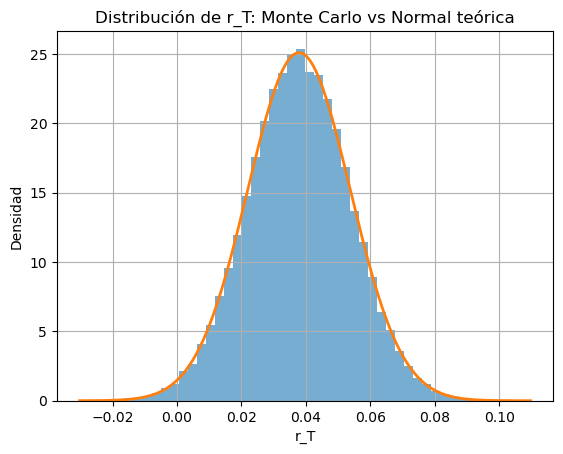

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del modelo de Vasicek

r0    = 0.03   # tasa corta inicial
kappa = 0.5    # velocidad de reversión a la media
theta = 0.05   # nivel de largo plazo
sigma = 0.02   # volatilidad
T     = 1.0    # horizonte (años)

M = 252        # número de pasos de tiempo
dt = T / M     # tamaño de paso

N = 100000     # número de trayectorias (Monte Carlo)

# Simulación Euler–Maruyama

# r_paths: trayectorias simuladas (N × (M+1))
r_paths = np.zeros((N, M + 1))
r_paths[:, 0] = r0

# shocks normales ~ N(0,1)
Z = np.random.randn(N, M)

for k in range(M):
    r_t = r_paths[:, k]
    drift = kappa * (theta - r_t) * dt
    diffusion = sigma * np.sqrt(dt) * Z[:, k]
    r_paths[:, k + 1] = r_t + drift + diffusion

# tasa al tiempo T
r_T = r_paths[:, -1]

# Momentos Monte Carlo

mu_mc  = np.mean(r_T)          # media empírica
var_mc = np.var(r_T, ddof=1)   # varianza empírica (muestral)

# Momentos analíticos bajo Vasicek

mu_exact = theta + (r0 - theta) * np.exp(-kappa * T)
var_exact = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * T))

# Errores

abs_error_mu = abs(mu_mc - mu_exact)
rel_error_mu = abs_error_mu / abs(mu_exact)

abs_error_var = abs(var_mc - var_exact)
rel_error_var = abs_error_var / abs(var_exact)

print("=== Resultados Monte Carlo vs Analítico ===")
print(f"Media MC       : {mu_mc:.6f}")
print(f"Media exacta   : {mu_exact:.6f}")
print(f"Error abs. µ   : {abs_error_mu:.6e}")
print(f"Error rel. µ   : {rel_error_mu:.6e}")
print()
print(f"Varianza MC    : {var_mc:.6f}")
print(f"Varianza exacta: {var_exact:.6f}")
print(f"Error abs. Var : {abs_error_var:.6e}")
print(f"Error rel. Var : {rel_error_var:.6e}")

# Histograma y densidad normal teórica

plt.figure()
plt.hist(r_T, bins=50, density=True, alpha=0.6)  # histograma normalizado

sigma_T = np.sqrt(var_exact)
x = np.linspace(min(r_T), max(r_T), 500)
pdf = (1 / (np.sqrt(2 * np.pi) * sigma_T)) * np.exp(-0.5 * ((x - mu_exact) / sigma_T)**2)

plt.plot(x, pdf, linewidth=2)
plt.xlabel("r_T")
plt.ylabel("Densidad")
plt.title("Distribución de r_T: Monte Carlo vs Normal teórica")
plt.grid(True)
plt.show()

Contrato Forward de tasa


=== Cálculo del valor de referencia (N_ref) ===
Valor de referencia (N_ref = 1000000): -0.00216594

=== Resultados Forward por N ===
N		V_hat		Var(estimador)		Error rel.
100     	-0.00239504	2.13761309e-04	1.058e-01
500     	-0.00285478	2.20376989e-04	3.180e-01
1000    	-0.00182540	2.29888789e-04	1.572e-01
5000    	-0.00168733	2.28838342e-04	2.210e-01
10000   	-0.00206421	2.33023539e-04	4.697e-02
50000   	-0.00217095	2.35594899e-04	2.313e-03


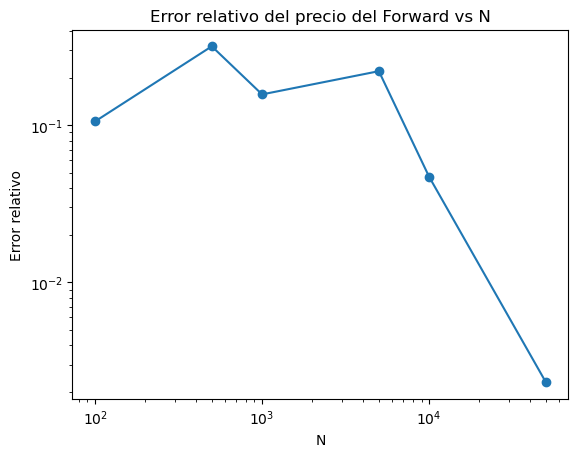

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del modelo de Vasicek

r0    = 0.03   # tasa corta inicial
kappa = 0.5    # velocidad de reversión a la media
theta = 0.05   # nivel de largo plazo
sigma = 0.02   # volatilidad
T     = 1.0    # horizonte (años)

M = 252        # número de pasos de tiempo
dt = T / M     # tamaño de paso

N = 100000     # número de trayectorias (Monte Carlo)

# Parámetro del Forward
K = 0.04   # tasa fija (strike) del forward

# función auxiliar: simula trayectorias de Vasicek y devuelve r_paths completo
def sim_vasicek_paths(N_paths):
    r_paths = np.zeros((N_paths, M + 1))
    r_paths[:, 0] = r0
    Z = np.random.randn(N_paths, M)
    for k in range(M):
        r_t = r_paths[:, k]
        drift = kappa * (theta - r_t) * dt
        diffusion = sigma * np.sqrt(dt) * Z[:, k]
        r_paths[:, k + 1] = r_t + drift + diffusion
    return r_paths

# función Monte Carlo para el precio del forward para un N dado
def mc_forward_price(N_paths):
    r_paths = sim_vasicek_paths(N_paths)
    r_T = r_paths[:, -1]              # tasa al vencimiento T
    # factor de descuento: D_T ≈ exp(-∑ r_k Δt)
    int_r = np.sum(r_paths[:, :-1], axis=1) * dt
    D_T = np.exp(-int_r)
    payoff = D_T * (r_T - K)          # payoff descontado
    V_hat = np.mean(payoff)           # estimador MC del precio
    var_hat = np.var(payoff, ddof=1)  # varianza muestral del estimador
    return V_hat, var_hat

# conjunto de tamaños de muestra N para el TP
N_list = [100, 500, 1000, 5000, 10000, 50000]

# N de referencia para "valor verdadero" 
N_ref = 1000000

print("\n=== Cálculo del valor de referencia (N_ref) ===")
V_ref, _ = mc_forward_price(N_ref)
print(f"Valor de referencia (N_ref = {N_ref}): {V_ref:.8f}")

# loop sobre N para estimar precio, varianza y error relativo

results = []  # almacenará (N, V_hat, var_hat, rel_error)

for N_MC in N_list:
    V_hat, var_hat = mc_forward_price(N_MC)
    rel_error = abs(V_hat - V_ref) / abs(V_ref)
    results.append((N_MC, V_hat, var_hat, rel_error))

print("\n=== Resultados Forward por N ===")
print("N\t\tV_hat\t\tVar(estimador)\t\tError rel.")
for N_MC, V_hat, var_hat, rel_error in results:
    print(f"{N_MC:<8d}\t{V_hat:.8f}\t{var_hat:.8e}\t{rel_error:.3e}")

# gráfico error relativo vs N

Ns = np.array([r[0] for r in results])
errors = np.array([r[3] for r in results])

plt.figure()
plt.loglog(Ns, errors, marker="o")   # escala log-log para visualizar convergencia
plt.xlabel("N")
plt.ylabel("Error relativo")
plt.title("Error relativo del precio del Forward vs N")
plt.show()